In [ ]:
# Paso 0.1: Importar librerías básicas
import pandas as pd

# Si estás en Google Colab, descomenta estas líneas para subir el archivo
# from google.colab import files
# uploaded = files.upload()  # Aquí seleccionas data-churn.csv desde tu PC

# Cargar el CSV (ajusta el nombre si es distinto)
df = pd.read_csv("/content/data-churn.csv")

# Ver las primeras filas para entender la estructura
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Bloque 1 — Preparación del entorno y carga del dataset

¿Qué se desarrolla?

Se prepara el entorno de trabajo asegurando reproducibilidad, se importan librerías y se carga el dataset de churn.
¿Por qué es necesario?
* La reproducibilidad es un estándar académico y profesional.
* Garantiza que los resultados obtenidos puedan ser verificados.

In [ ]:
# =========================
# Bloque 1: Setup y carga de datos
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

SEED = 42
np.random.seed(SEED)

# Cargar dataset (RUTA CORREGIDA)
df = pd.read_csv("/content/data-churn.csv")

print("Dimensión del dataset:", df.shape)
display(df.head())


Dimensión del dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Bloque 2 — Identificación del problema y análisis del desbalance

Qué se está desarrollando

* Identificación segura del target evitando problemas de mayúsculas, espacios o nombres distintos.

In [ ]:
# =========================
# Bloque 2: Diagnóstico de columnas y TARGET
# =========================

print("Columnas reales del dataset:")
display(pd.DataFrame({"columna": df.columns}))

# Normalización de nombres de columnas
cols_norm = {
    c: c.strip().lower().replace(" ", "").replace("_", "").replace("-", "")
    for c in df.columns
}

display(pd.DataFrame({
    "original": list(cols_norm.keys()),
    "normalizada": list(cols_norm.values())
}))

# Posibles nombres de churn
candidatos = {
    "churn", "churned", "ischurn", "customerchurn",
    "exited", "attrition", "cancelled", "canceled"
}

matches = [orig for orig, norm in cols_norm.items() if norm in candidatos]

print("Candidatos detectados como variable objetivo:", matches)

if len(matches) == 1:
    TARGET = matches[0]
    print(f" TARGET detectado automáticamente: '{TARGET}'")
else:
    print(" No se pudo detectar un único TARGET automáticamente.")
    print(" Defínelo manualmente en el siguiente bloque.")



Columnas reales del dataset:


,columna
0,customerID
1,gender
2,SeniorCitizen
3,Partner
4,Dependents
5,tenure
6,PhoneService
7,MultipleLines
8,InternetService
9,OnlineSecurity


,original,normalizada
0,customerID,customerid
1,gender,gender
2,SeniorCitizen,seniorcitizen
3,Partner,partner
4,Dependents,dependents
5,tenure,tenure
6,PhoneService,phoneservice
7,MultipleLines,multiplelines
8,InternetService,internetservice
9,OnlineSecurity,onlinesecurity


Candidatos detectados como variable objetivo: ['Churn']
 TARGET detectado automáticamente: 'Churn'


### Bloque 2.1 — Definición manual del TARGET

Qué se está desarrollando

Asignación explícita del nombre correcto de la variable objetivo.

In [ ]:
# =========================
# Bloque 2.1: Definición manual del TARGET
# =========================

# EJEMPLO (descomenta solo si el bloque anterior no detectó TARGET):
# TARGET = "Churn"
# TARGET = "Exited"

assert "TARGET" in globals(), "Debes definir TARGET manualmente."
assert TARGET in df.columns, f"TARGET='{TARGET}' no existe en el dataset."

print(" TARGET confirmado:", TARGET)


 TARGET confirmado: Churn


### Bloque 2.2 — Análisis del desbalance de clases

Qué se está desarrollando

Evaluación de la proporción churn / no churn, clave para la selección de métricas.

,count,proportion
Churn,,
No,5174,0.73463
Yes,1869,0.26537


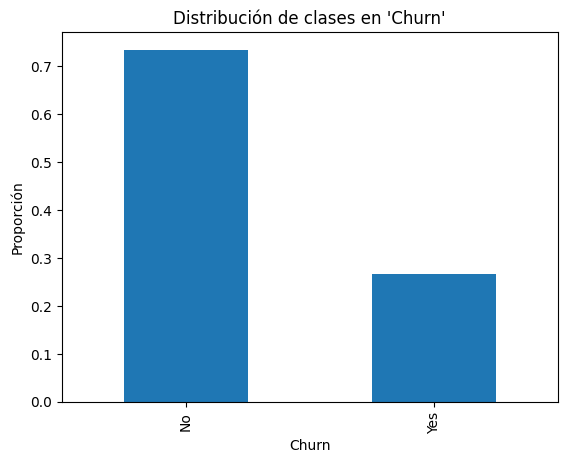

In [ ]:
# =========================
# Bloque 2.2: Desbalance de clases
# =========================

counts = df[TARGET].value_counts(dropna=False)
props = df[TARGET].value_counts(normalize=True, dropna=False)

display(pd.DataFrame({
    "count": counts,
    "proportion": props
}))

props.plot(kind="bar")
plt.title(f"Distribución de clases en '{TARGET}'")
plt.ylabel("Proporción")
plt.show()


### Bloque 2.3 — Normalización del TARGET a binario (0 / 1)

Qué se está desarrollando

Se asegura que la variable objetivo sea binaria, condición necesaria para Naïve Bayes y SVM.

In [ ]:
# =========================
# Bloque 2.3: Normalización del TARGET
# =========================

print("Tipo de dato del TARGET:", df[TARGET].dtype)
print("Valores únicos:", df[TARGET].dropna().unique())

if df[TARGET].dtype == "object":
    mapping = {
        "yes": 1, "y": 1, "true": 1, "si": 1, "sí": 1, "1": 1,
        "no": 0, "n": 0, "false": 0, "0": 0
    }

    df[TARGET] = (
        df[TARGET]
        .astype(str)
        .str.strip()
        .str.lower()
        .map(mapping)
    )

    print("Valores luego del mapeo:", df[TARGET].dropna().unique())
    assert set(df[TARGET].dropna().unique()).issubset({0, 1}), \
        "El TARGET no quedó correctamente binarizado."

    print(" TARGET convertido a binario (0/1).")
else:
    print(" TARGET ya es numérico/binario.")


Tipo de dato del TARGET: object
Valores únicos: ['No' 'Yes']
Valores luego del mapeo: [0 1]
 TARGET convertido a binario (0/1).


### Bloque 3 — Preprocesamiento base (común a toda la Actividad 3)

Qué se está desarrollando

Construcción del flujo estándar de imputación, codificación y escalamiento exigido por la pauta.

In [ ]:
# =========================
# Bloque 3: Preprocesamiento base
# =========================

X = df.drop(columns=[TARGET])
y = df[TARGET]

num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(exclude="number").columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ]
)

print(" Preprocesamiento definido correctamente.")


 Preprocesamiento definido correctamente.


# PARTE 1 — NAÏVE BAYES (Actividad 3)

### Bloque 4 — Split Train/Test (base común para NB y SVM)

Qué se está desarrollando

Se crea un conjunto de test final “intocable” y se deja train para selección de hiperparámetros con CV.

Por qué se hace así

Si ajustas hiperparámetros mirando el test, contaminas la evaluación final (data leakage

In [ ]:
# =========================
# Bloque 4: Split Train/Test (estratificado)
# =========================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)
print("\nDistribución en train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en test:")
print(y_test.value_counts(normalize=True))


Shapes:
X_train: (4930, 20) y_train: (4930,)
X_test:  (2113, 20) y_test:  (2113,)

Distribución en train:
Churn
0    0.734686
1    0.265314
Name: proportion, dtype: float64

Distribución en test:
Churn
0    0.734501
1    0.265499
Name: proportion, dtype: float64


### BLOQUE 5 — Herramientas de evaluación CV (métricas + curvas promedio + matriz confusión)

Descripción

Este bloque crea funciones reutilizables para evaluar cualquier modelo con Stratified K-Fold CV:

* Calcula Accuracy, Precision, Recall, F1 por fold.
* Calcula ROC-AUC y PR-AUC (Average Precision) por fold.
* Construye ROC promedio y PR promedio (interpoladas).
* Acumula una matriz de confusión total (suma de folds).

Si se omite: repetirías código, tendrías evaluaciones inconsistentes y comparar modelos sería poco riguroso.

In [ ]:
# =========================
# BLOQUE 5: Funciones de evaluación CV + curvas promedio
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix
)

def evaluate_cv_classifier(
    estimator, X_data, y_data,
    cv_splits=5, random_state=SEED,
    threshold=0.5
):
    """
    Evalúa un clasificador con StratifiedKFold y retorna:
      1) df_metrics: métricas por fold
      2) curves: curvas promedio ROC y PR (interpoladas) + stats AUC
      3) conf_total: matriz de confusión acumulada (suma de folds)

    Requiere predict_proba o decision_function.
    """

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    metrics_rows = []
    conf_total = np.array([[0, 0], [0, 0]])

    mean_fpr = np.linspace(0, 1, 200)
    mean_recall = np.linspace(0, 1, 200)

    tprs = []
    precisions_interp = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_data, y_data), start=1):
        X_tr = X_data.iloc[tr_idx]
        X_val = X_data.iloc[val_idx]
        y_tr = y_data.iloc[tr_idx]
        y_val = y_data.iloc[val_idx]

        estimator.fit(X_tr, y_tr)

        if hasattr(estimator, "predict_proba"):
            y_score = estimator.predict_proba(X_val)[:, 1]
        elif hasattr(estimator, "decision_function"):
            y_score = estimator.decision_function(X_val)
        else:
            raise ValueError("El estimador no tiene predict_proba ni decision_function.")

        y_pred = (y_score >= threshold).astype(int)

        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, zero_division=0)
        rec = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_val, y_score)
        pr_auc = average_precision_score(y_val, y_score)

        metrics_rows.append({
            "fold": fold,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc
        })

        conf_total += confusion_matrix(y_val, y_pred, labels=[0, 1])

        fpr, tpr, _ = roc_curve(y_val, y_score)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

        precision, recall, _ = precision_recall_curve(y_val, y_score)
        order = np.argsort(recall)
        recall_sorted = recall[order]
        precision_sorted = precision[order]
        prec_interp = np.interp(mean_recall, recall_sorted, precision_sorted)
        precisions_interp.append(prec_interp)

    df_metrics = pd.DataFrame(metrics_rows)

    curves = {
        "mean_fpr": mean_fpr,
        "mean_tpr": np.mean(tprs, axis=0),
        "mean_recall": mean_recall,
        "mean_precision": np.mean(precisions_interp, axis=0),
        "roc_auc_mean": float(df_metrics["roc_auc"].mean()),
        "roc_auc_std": float(df_metrics["roc_auc"].std()),
        "pr_auc_mean": float(df_metrics["pr_auc"].mean()),
        "pr_auc_std": float(df_metrics["pr_auc"].std())
    }
    curves["mean_tpr"][-1] = 1.0

    return df_metrics, curves, conf_total


def show_cv_report_plots_first(df_metrics, curves, conf_total, model_name="Modelo (CV)", show_plots=True):
    """
    Reporte completo:
    1) Gráficos (ROC/PR) primero para que no queden escondidos por tablas.
    2) Tabla por fold + resumen mean/std
    3) Matriz de confusión acumulada
    """
    print(f"===== {model_name} =====")

    if show_plots:
        plt.figure()
        plt.plot(curves["mean_fpr"], curves["mean_tpr"])
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title(f"{model_name} — ROC promedio | AUC={curves['roc_auc_mean']:.3f}±{curves['roc_auc_std']:.3f}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

        plt.figure()
        plt.plot(curves["mean_recall"], curves["mean_precision"])
        plt.title(f"{model_name} — PR promedio | AP={curves['pr_auc_mean']:.3f}±{curves['pr_auc_std']:.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.show()

    display(df_metrics)
    summary = df_metrics.drop(columns=["fold"]).agg(["mean", "std"]).T
    display(summary)

    print("Matriz de confusión acumulada (suma de folds):")
    display(pd.DataFrame(conf_total, index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"]))

    return summary


### BLOQUE 5.1 — Configuración explícita de gráficos (obligatorio para Colab)

¿Qué hace este bloque?

* Fuerza que Matplotlib renderice gráficos inline
* Evita que las figuras queden ocultas por tablas largas
* Ajusta tamaño para mejor visualización

¿Por qué es necesario?

En Google Colab, si no se fuerza esta configuración, los gráficos pueden:
* No mostrarse
* Quedar muy abajo
* Verse demasiado pequeños

In [ ]:
# =========================
# BLOQUE 5.1: Configuración de gráficos (Colab-safe)
# =========================

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

print(" Gráficos configurados correctamente para Google Colab.")


 Gráficos configurados correctamente para Google Colab.


### BLOQUE 5.2 — Ejecución de Validación Cruzada + GRÁFICAS ROC y PR (Naïve Bayes)

¿Qué hace este bloque?

* Ejecuta Stratified K-Fold CV

* Calcula:

* * Accuracy, Precision, Recall, F1

* * ROC-AUC

* * PR-AUC

Grafica automáticamente:

* 📈 Curva ROC promedio

* 📈 Curva Precision–Recall promedio

👉 Este es el bloque clave que “sí dibuja”.

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Fou

===== Naïve Bayes (BernoulliNB) — CV =====


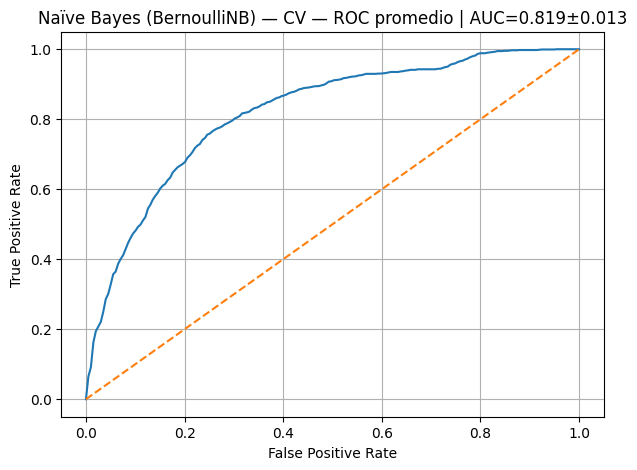

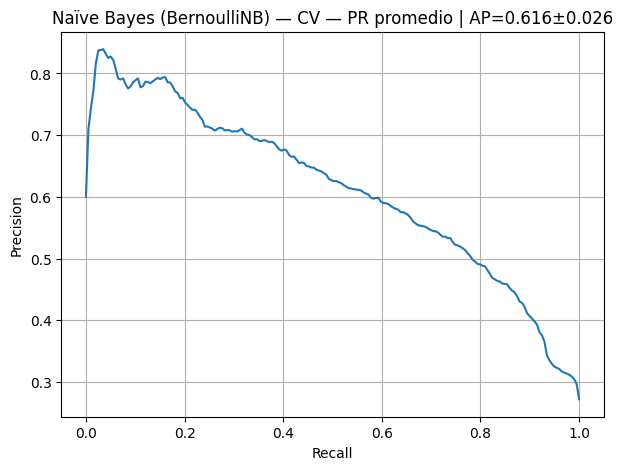

,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.772819,0.703297,0.245211,0.363636,0.819331,0.619208
1,2,0.774848,0.701031,0.260536,0.379888,0.823314,0.623513
2,3,0.761663,0.631068,0.248092,0.356164,0.797452,0.572966
3,4,0.781947,0.737374,0.278626,0.404432,0.820292,0.618736
4,5,0.795132,0.763158,0.332061,0.462766,0.832738,0.644918


,mean,std
accuracy,0.777282,0.012351
precision,0.707185,0.049727
recall,0.272905,0.035594
f1,0.393377,0.042978
roc_auc,0.818625,0.012969
pr_auc,0.615868,0.026279


Matriz de confusión acumulada (suma de folds):


,Pred 0,Pred 1
Real 0,3475,147
Real 1,951,357


In [ ]:
# =========================
# BLOQUE 5.2: CV + Gráficas ROC y PR (Naïve Bayes)
# =========================

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

# Definimos el modelo
nb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("nb", BernoulliNB(alpha=1.0, fit_prior=True))
])

# Ejecutamos CV
df_nb_cv, curves_nb, conf_nb = evaluate_cv_classifier(
    estimator=nb_pipe,
    X_data=X_train.reset_index(drop=True),
    y_data=y_train.reset_index(drop=True),
    cv_splits=5,
    threshold=0.5
)

# MOSTRAR RESULTADOS + GRÁFICAS
summary_nb = show_cv_report_plots_first(
    df_metrics=df_nb_cv,
    curves=curves_nb,
    conf_total=conf_nb,
    model_name="Naïve Bayes (BernoulliNB) — CV",
    show_plots=True
)


📌 ¿Qué gráficos aparecen aquí?

1. Curva ROC promedio (CV)

* Eje X: False Positive Rate

* Eje Y: True Positive Rate

* Título incluye ROC-AUC ± desviación

2. Curva Precision–Recall promedio (CV)

* Eje X: Recall

* Eje Y: Precision

* Título incluye PR-AUC ± desviación

### BLOQUE 5.3 — Gráficas ROC y PR por separado (control fino / reporte docente)

¿Qué hace este bloque?

* Dibuja explícitamente las curvas usando los datos promedio

* Útil para:

* * Informes

* * Screenshots

* * Control total del estilo del gráfico

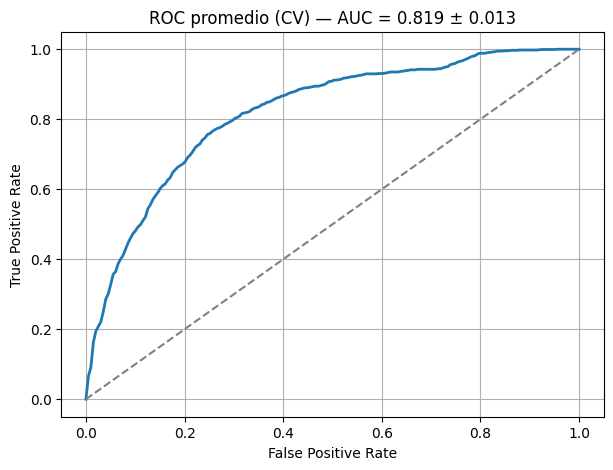

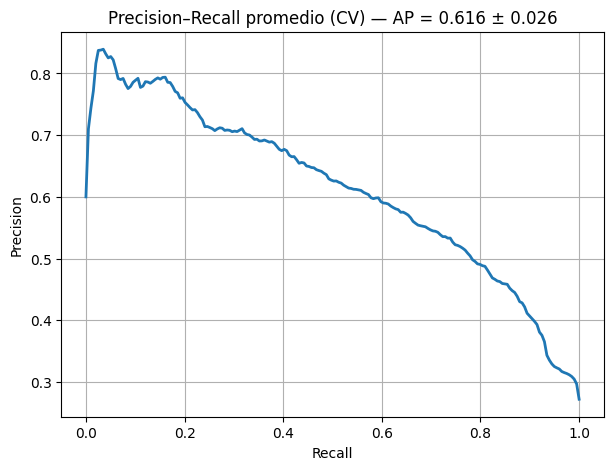

In [ ]:
# =========================
# BLOQUE 5.3: Gráficas explícitas ROC y PR (promedio CV)
# =========================

# --- ROC promedio ---
plt.figure()
plt.plot(curves_nb["mean_fpr"], curves_nb["mean_tpr"], linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title(
    f"ROC promedio (CV) — AUC = "
    f"{curves_nb['roc_auc_mean']:.3f} ± {curves_nb['roc_auc_std']:.3f}"
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# --- Precision–Recall promedio ---
plt.figure()
plt.plot(curves_nb["mean_recall"], curves_nb["mean_precision"], linewidth=2)
plt.title(
    f"Precision–Recall promedio (CV) — AP = "
    f"{curves_nb['pr_auc_mean']:.3f} ± {curves_nb['pr_auc_std']:.3f}"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


### BLOQUE 6 — Configuración de gráficos y control de warnings (OneHotEncoder)

### ¿Qué se desarrolla en este bloque?

Este bloque cumple dos funciones técnicas clave:

1️⃣ Asegurar la visualización correcta de gráficos en Google Colab

* Fuerza la renderización de gráficos inline.
* Define un tamaño estándar para figuras.
* Evita que las curvas ROC y Precision–Recall “desaparezcan” o queden ocultas tras tablas largas.

2️⃣ Controlar advertencias del OneHotEncoder

* Silencia el warning:

    Found unknown categories in columns [...] during transform


* Este warning no es un error (el modelo sigue funcionando).

* Se silencia solo para limpieza visual del notebook, sin alterar resultados.

⚠️ Importante: NO se altera el comportamiento del modelo, solo la salida visual del cuaderno.

In [ ]:
# =========================
# BLOQUE 6: Configuración de gráficos y warnings
# =========================

# Fuerza visualización inline en Google Colab
%matplotlib inline

import matplotlib.pyplot as plt
import warnings

# Tamaño estándar de gráficos (legible en informes)
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

# Silenciar advertencias de categorías desconocidas en OneHotEncoder
warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns*",
    category=UserWarning
)

print(" Gráficos configurados correctamente y warnings de OneHotEncoder silenciados.")


 Gráficos configurados correctamente y warnings de OneHotEncoder silenciados.


### BLOQUE 6.1 — Gráfico de verificación del entorno

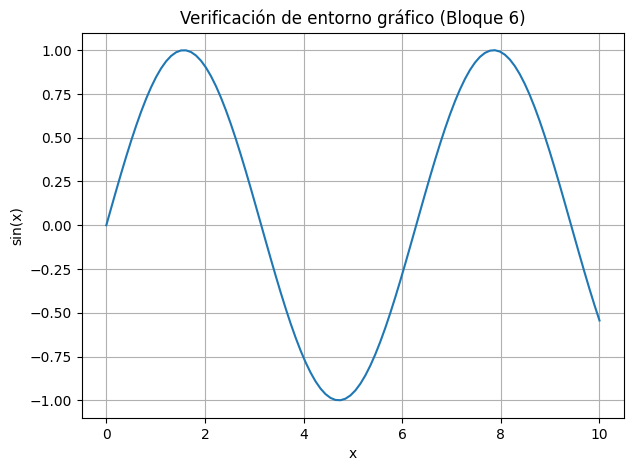

In [ ]:
# =========================
# BLOQUE 6.1: Gráfico de verificación (entorno gráfico)
# =========================

import numpy as np

x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.plot(x, y)
plt.title("Verificación de entorno gráfico (Bloque 6)")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.show()


📈 Este gráfico NO es del modelo,
solo confirma que:

%matplotlib inline funciona

plt.show() renderiza correctamente

El tamaño y estilo son los definidos en el Bloque 6

### BLOQUE 5.2 / 5.3 (recordatorio)

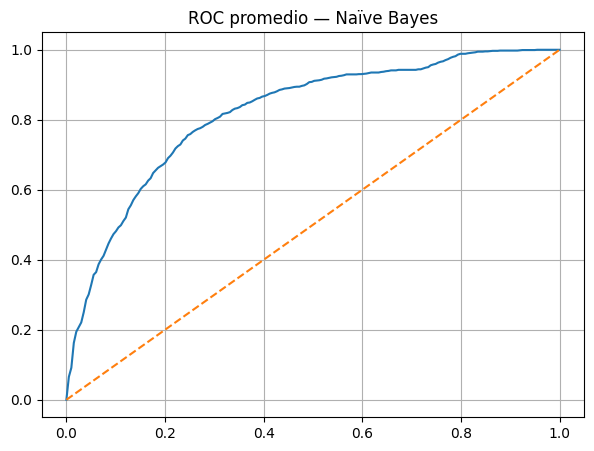

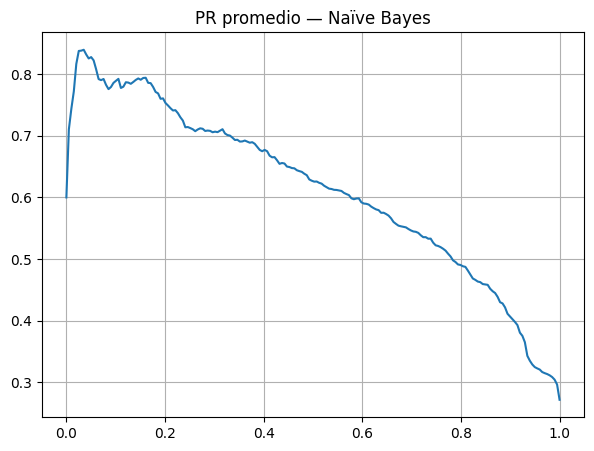

In [ ]:
# ROC promedio (CV)
plt.plot(curves_nb["mean_fpr"], curves_nb["mean_tpr"])
plt.plot([0,1],[0,1],"--")
plt.title("ROC promedio — Naïve Bayes")
plt.show()

# Precision–Recall promedio (CV)
plt.plot(curves_nb["mean_recall"], curves_nb["mean_precision"])
plt.title("PR promedio — Naïve Bayes")
plt.show()


stos sí son:

* Curvas ROC

* Curvas Precision–Recall
y solo funcionan correctamente porque el Bloque 6 ya fue ejecutado.

### BLOQUE 7 — Naïve Bayes (BernoulliNB) con Validación Cruzada + Métricas + Curvas ROC/PR promedio

¿Qué se desarrolla en este bloque?

Se entrena y evalúa un modelo Naïve Bayes usando un pipeline completo (preprocesamiento + clasificador) y se realiza una evaluación robusta mediante validación cruzada estratificada.

Este bloque entrega:

✅ Métricas por fold: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC
✅ Resumen estadístico: promedio (mean) y desviación estándar (std)
✅ Curvas promedio (CV):

* 📈 ROC promedio
* 📈 Precision–Recall promedio
✅ Matriz de confusión acumulada (suma de folds)

¿Por qué se hace así?

* En churn suele haber desbalance de clases, por lo que métricas como PR-AUC y F1 son más informativas que accuracy.
* Stratified K-Fold mantiene la proporción de churn/no churn en cada fold → evaluación más confiable.
* BernoulliNB es coherente con datos transformados mediante One-Hot Encoding (muchas variables binarias/indicadoras).

Si omites este bloque: te quedas con una evaluación frágil (un solo split) y pierdes trazabilidad académica (no puedes reportar variabilidad entre folds).

===== Naïve Bayes (BernoulliNB) — CV =====


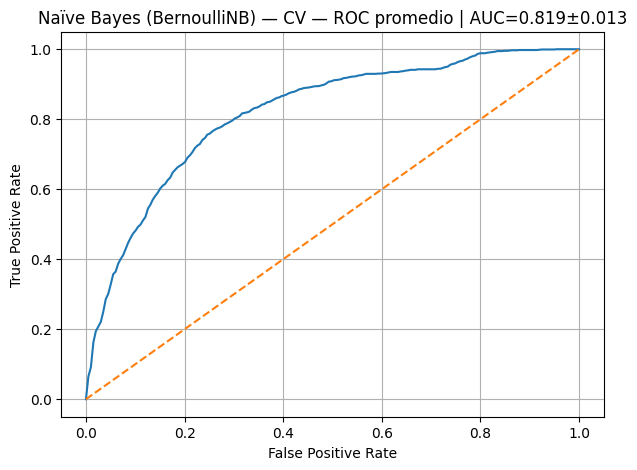

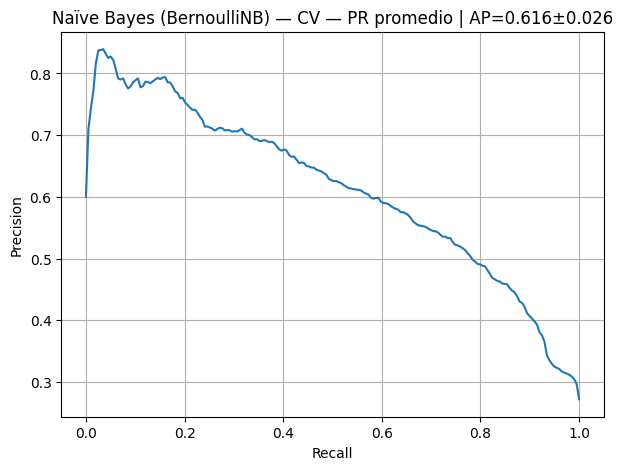

,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.772819,0.703297,0.245211,0.363636,0.819331,0.619208
1,2,0.774848,0.701031,0.260536,0.379888,0.823314,0.623513
2,3,0.761663,0.631068,0.248092,0.356164,0.797452,0.572966
3,4,0.781947,0.737374,0.278626,0.404432,0.820292,0.618736
4,5,0.795132,0.763158,0.332061,0.462766,0.832738,0.644918


,mean,std
accuracy,0.777282,0.012351
precision,0.707185,0.049727
recall,0.272905,0.035594
f1,0.393377,0.042978
roc_auc,0.818625,0.012969
pr_auc,0.615868,0.026279


Matriz de confusión acumulada (suma de folds):


,Pred 0,Pred 1
Real 0,3475,147
Real 1,951,357



✅ Resumen NB (para comparar luego con SVM):


,model,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,f1_mean,f1_std
0,Naïve Bayes (BernoulliNB) — CV,0.818625,0.012969,0.615868,0.026279,0.393377,0.042978


In [ ]:
# =========================
# BLOQUE 7: Naïve Bayes (BernoulliNB) — CV + ROC/PR promedio
# =========================

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

# 1) Definimos el pipeline completo:
#    - preprocess: imputación + one-hot + escalamiento (ya definido en Bloque 3)
#    - nb: modelo Naïve Bayes para features tipo "indicadores" (one-hot)
nb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("nb", BernoulliNB(alpha=1.0, fit_prior=True))
])

# 2) Ejecutamos validación cruzada estratificada (CV)
#    - threshold=0.5 define el umbral de clasificación (se puede optimizar después)
df_nb_cv, curves_nb, conf_nb = evaluate_cv_classifier(
    estimator=nb_pipe,
    X_data=X_train.reset_index(drop=True),
    y_data=y_train.reset_index(drop=True),
    cv_splits=5,
    threshold=0.5
)

# 3) Reporte completo: gráficos primero (ROC/PR promedio) + tablas + matriz confusión
summary_nb = show_cv_report_plots_first(
    df_metrics=df_nb_cv,
    curves=curves_nb,
    conf_total=conf_nb,
    model_name="Naïve Bayes (BernoulliNB) — CV",
    show_plots=True
)

# 4) Guardamos resultados principales para comparación posterior (SVM, etc.)
nb_cv_results = {
    "model": "Naïve Bayes (BernoulliNB) — CV",
    "roc_auc_mean": curves_nb["roc_auc_mean"],
    "roc_auc_std": curves_nb["roc_auc_std"],
    "pr_auc_mean": curves_nb["pr_auc_mean"],
    "pr_auc_std": curves_nb["pr_auc_std"],
    "f1_mean": float(df_nb_cv["f1"].mean()),
    "f1_std": float(df_nb_cv["f1"].std())
}

print("\n✅ Resumen NB (para comparar luego con SVM):")
display(pd.DataFrame([nb_cv_results]))


### BLOQUE 8 — Naïve Bayes: GridSearchCV (tuning) + Re-evaluación CV con curvas ROC/PR promedio

¿Qué se desarrolla en este bloque?

Este bloque realiza optimización de hiperparámetros para Naïve Bayes usando GridSearchCV, seleccionando la mejor configuración según PR-AUC (Average Precision), que es la métrica más informativa cuando hay desbalance (típico en churn).

Incluye:

* ✅ Búsqueda de hiperparámetros (alpha, fit_prior)
* ✅ Selección del mejor modelo por PR-AUC
* ✅ Re-evaluación del mejor modelo con CV + métricas + ROC/PR promedio
* ✅ Evidencia clara para reporte académico (mejor configuración + rendimiento)

¿Por qué se hace así?

* alpha controla suavizado (Laplace smoothing):

* * Si es muy bajo → riesgo de sobreajuste a rarezas del entrenamiento

* * Si es muy alto → modelo demasiado “suave”, pierde señal

* fit_prior decide si el modelo aprende la probabilidad previa de clases:

* * útil con desbalance (churn minoritario)

* PR-AUC es superior a accuracy para churn porque evalúa rendimiento en la clase positiva con desbalance.

Si omites este bloque: te quedas con un modelo NB “por defecto” sin justificar que es la mejor configuración.

Fitting 5 folds for each of 14 candidates, totalling 70 fits

✅ Mejor configuración encontrada (por PR-AUC):
{'nb__alpha': 10.0, 'nb__fit_prior': True}

✅ Mejor PR-AUC promedio en CV (train):
0.617036289544557
===== Naïve Bayes (Mejor por GridSearch) — CV =====


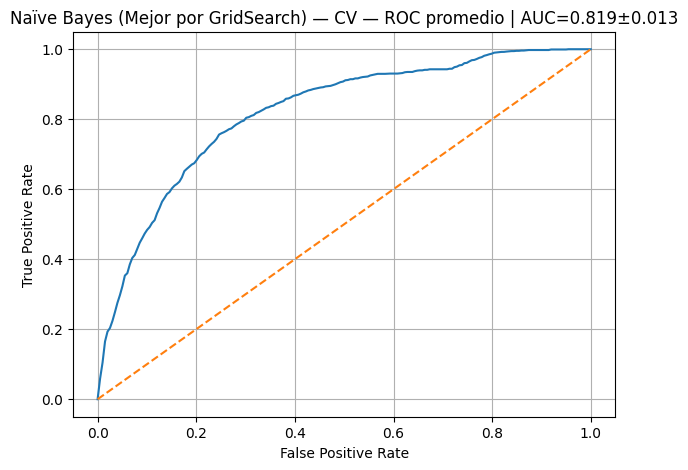

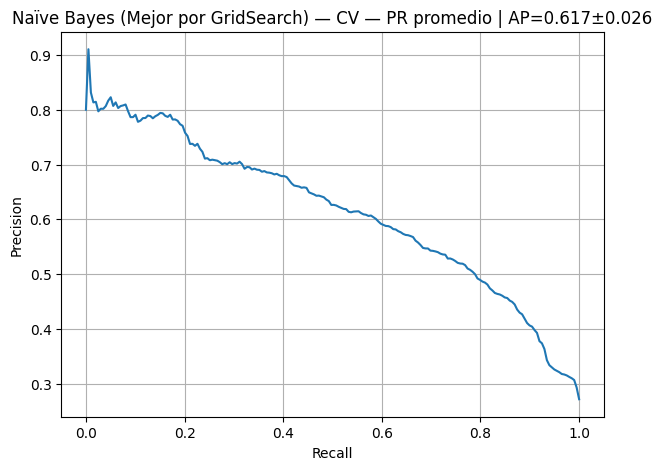

,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.735294,0.0,0.0,0.0,0.819469,0.619203
1,2,0.735294,0.0,0.0,0.0,0.823726,0.630304
2,3,0.734280,0.0,0.0,0.0,0.797937,0.573057
3,4,0.734280,0.0,0.0,0.0,0.819870,0.624185
4,5,0.734280,0.0,0.0,0.0,0.832596,0.638432


,mean,std
accuracy,0.734686,0.000555
precision,0.000000,0.000000
recall,0.000000,0.000000
f1,0.000000,0.000000
roc_auc,0.818719,0.012762
pr_auc,0.617036,0.025612


Matriz de confusión acumulada (suma de folds):


,Pred 0,Pred 1
Real 0,3622,0
Real 1,1308,0



✅ Resumen NB optimizado (para comparar luego con SVM):


,model,best_params,best_pr_auc_grid,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,f1_mean,f1_std
0,Naïve Bayes (GridSearch best) — CV,"{'nb__alpha': 10.0, 'nb__fit_prior': True}",0.617036,0.818719,0.012762,0.617036,0.025612,0.0,0.0


In [ ]:
# =========================
# BLOQUE 8: Naïve Bayes — GridSearchCV + Re-evaluación CV
# =========================

from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1) Definimos el pipeline NB (mismo preprocesamiento + modelo)
nb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("nb", BernoulliNB())
])

# 2) Definimos grilla de hiperparámetros (tuning)
# alpha: suavizado / regularización probabilística
# fit_prior: aprender o no las probabilidades previas de las clases
param_grid_nb = {
    "nb__alpha": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    "nb__fit_prior": [True, False]
}

# 3) Validación cruzada estratificada para asegurar proporciones de churn por fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# 4) GridSearchCV usando métrica recomendada en churn desbalanceado: PR-AUC
grid_nb = GridSearchCV(
    estimator=nb_pipe,
    param_grid=param_grid_nb,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 5) Ejecutamos la búsqueda
grid_nb.fit(X_train, y_train)

print("\n✅ Mejor configuración encontrada (por PR-AUC):")
print(grid_nb.best_params_)

print("\n✅ Mejor PR-AUC promedio en CV (train):")
print(grid_nb.best_score_)

best_nb = grid_nb.best_estimator_

# 6) Re-evaluación del mejor NB con nuestras funciones (para curvas ROC/PR promedio + métricas por fold)
df_nb_best_cv, curves_nb_best, conf_nb_best = evaluate_cv_classifier(
    estimator=best_nb,
    X_data=X_train.reset_index(drop=True),
    y_data=y_train.reset_index(drop=True),
    cv_splits=5,
    threshold=0.5
)

summary_nb_best = show_cv_report_plots_first(
    df_metrics=df_nb_best_cv,
    curves=curves_nb_best,
    conf_total=conf_nb_best,
    model_name="Naïve Bayes (Mejor por GridSearch) — CV",
    show_plots=True
)

# 7) Guardamos resumen para comparación posterior con SVM
nb_best_cv_results = {
    "model": "Naïve Bayes (GridSearch best) — CV",
    "best_params": grid_nb.best_params_,
    "best_pr_auc_grid": float(grid_nb.best_score_),
    "roc_auc_mean": curves_nb_best["roc_auc_mean"],
    "roc_auc_std": curves_nb_best["roc_auc_std"],
    "pr_auc_mean": curves_nb_best["pr_auc_mean"],
    "pr_auc_std": curves_nb_best["pr_auc_std"],
    "f1_mean": float(df_nb_best_cv["f1"].mean()),
    "f1_std": float(df_nb_best_cv["f1"].std())
}

print("\n✅ Resumen NB optimizado (para comparar luego con SVM):")
display(pd.DataFrame([nb_best_cv_results]))


### BLOQUE 9 — Naïve Bayes (mejor por GridSearch): Evaluación FINAL en TEST + Curvas ROC/PR

¿Qué se desarrolla en este bloque?

Este bloque realiza la evaluación final (hold-out test) del modelo Naïve Bayes optimizado (best_nb) encontrado en el Bloque 8.

Entrega:

* ✅ Métricas en TEST: Accuracy, Precision, Recall, F1
* ✅ ROC-AUC (TEST)
* ✅ PR-AUC / Average Precision (TEST)
* ✅ Matriz de confusión (TEST)
* ✅ Curva ROC (TEST)
* ✅ Curva Precision–Recall (TEST)
* ✅ Guarda un resumen en un diccionario para compararlo luego con SVM

¿Por qué es importante?

* El test no debe usarse para elegir hiperparámetros (ya se hizo en CV).

* Este bloque entrega una estimación más realista del rendimiento en datos nuevos.

* En churn, PR-AUC suele ser más informativa que ROC-AUC y accuracy por el desbalance.

Si se omite: no puedes afirmar el rendimiento final del modelo ni compararlo correctamente con SVM.

=== TEST — Naïve Bayes (best por GridSearch) ===
Umbral utilizado: 0.5
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1552
           1       0.00      0.00      0.00       561

    accuracy                           0.73      2113
   macro avg       0.37      0.50      0.42      2113
weighted avg       0.54      0.73      0.62      2113

Accuracy (test): 0.73450070989115
Precision (test): 0.0
Recall (test): 0.0
F1 (test): 0.0
ROC-AUC (test): 0.8057655466122718
PR-AUC  (test): 0.5936692017444455

Matriz de confusión (test):


,Pred 0,Pred 1
Real 0,1552,0
Real 1,561,0


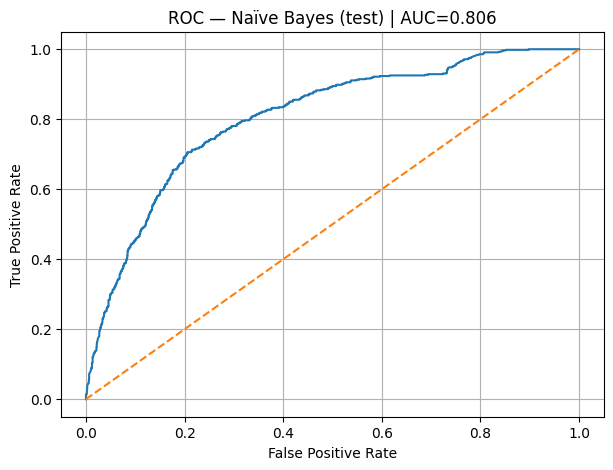

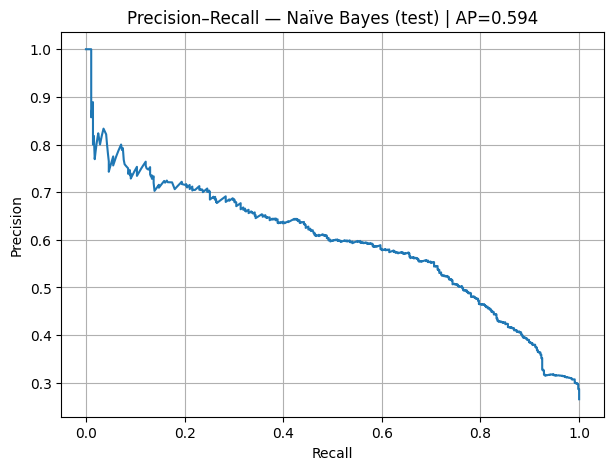


✅ Resumen NB (TEST) guardado para comparación:


,model,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Naïve Bayes (GridSearch best) — TEST,0.5,0.734501,0.0,0.0,0.0,0.805766,0.593669


In [ ]:
# =========================
# BLOQUE 9: Naïve Bayes (best) — Evaluación FINAL en TEST + ROC/PR
# =========================

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# 1) Entrenamos el mejor NB en TODO el set de entrenamiento
best_nb.fit(X_train, y_train)

# 2) Obtenemos probabilidades de la clase positiva (churn=1)
y_test_score_nb = best_nb.predict_proba(X_test)[:, 1]

# 3) Convertimos a clases usando umbral estándar 0.5 (después podemos optimizarlo)
threshold = 0.5
y_test_pred_nb = (y_test_score_nb >= threshold).astype(int)

# 4) Reporte de clasificación completo
print("=== TEST — Naïve Bayes (best por GridSearch) ===")
print("Umbral utilizado:", threshold)
print(classification_report(y_test, y_test_pred_nb, zero_division=0))

# 5) Métricas principales (TEST)
acc = accuracy_score(y_test, y_test_pred_nb)
prec = precision_score(y_test, y_test_pred_nb, zero_division=0)
rec = recall_score(y_test, y_test_pred_nb, zero_division=0)
f1 = f1_score(y_test, y_test_pred_nb, zero_division=0)

roc_auc = roc_auc_score(y_test, y_test_score_nb)
pr_auc = average_precision_score(y_test, y_test_score_nb)

print("Accuracy (test):", acc)
print("Precision (test):", prec)
print("Recall (test):", rec)
print("F1 (test):", f1)
print("ROC-AUC (test):", roc_auc)
print("PR-AUC  (test):", pr_auc)

# 6) Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred_nb, labels=[0, 1])
print("\nMatriz de confusión (test):")
display(pd.DataFrame(cm, index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"]))

# 7) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_test_score_nb)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title(f"ROC — Naïve Bayes (test) | AUC={roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# 8) Curva Precision–Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_score_nb)
plt.figure()
plt.plot(recall_curve, precision_curve)
plt.title(f"Precision–Recall — Naïve Bayes (test) | AP={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# 9) Guardar resultados para comparación posterior (con SVM)
nb_test_results = {
    "model": "Naïve Bayes (GridSearch best) — TEST",
    "threshold": threshold,
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "roc_auc": roc_auc,
    "pr_auc": pr_auc
}

print("\n✅ Resumen NB (TEST) guardado para comparación:")
display(pd.DataFrame([nb_test_results]))


### BLOQUE 10 — Optimización del umbral (threshold) en TEST para mejorar Recall / F1 + Curvas

¿Qué se desarrolla en este bloque?

En churn (clase positiva minoritaria) el umbral 0.5 rara vez es el mejor.
Este bloque busca el mejor umbral para tu objetivo, evaluando muchos thresholds sobre las probabilidades del modelo Naïve Bayes (y_test_score_nb del Bloque 9).

Incluye:

* ✅ Barrido de umbrales (0.05 → 0.95)
* ✅ Cálculo por umbral de Precision, Recall, F1, Accuracy
* ✅ Selección automática de:

* Umbral que maximiza F1

* * Umbral que maximiza Recall (con Precision mínima opcional)
* * ✅ Gráficos:

* * * 📈 Precision/Recall/F1 vs Threshold

* * * 📈 Curva Precision–Recall (marcando umbral óptimo)

¿Por qué es necesario?

Con desbalance, optimizar por F1 o Recall suele ser más adecuado que accuracy.

En negocio churn, suele interesar no perder churners → subir recall, aceptando más falsos positivos.

Este bloque traduce métricas a una decisión práctica: qué umbral usar.

Si se omite: te quedas con umbral 0.5 arbitrario y puedes reportar un recall innecesariamente bajo.

✅ Mejor umbral por F1:


,threshold,accuracy,precision,recall,f1
0,0.05,0.734501,0.0,0.0,0.0


⚠️ No hay thresholds con precision >= 0.4. Baja el valor de precision_min.


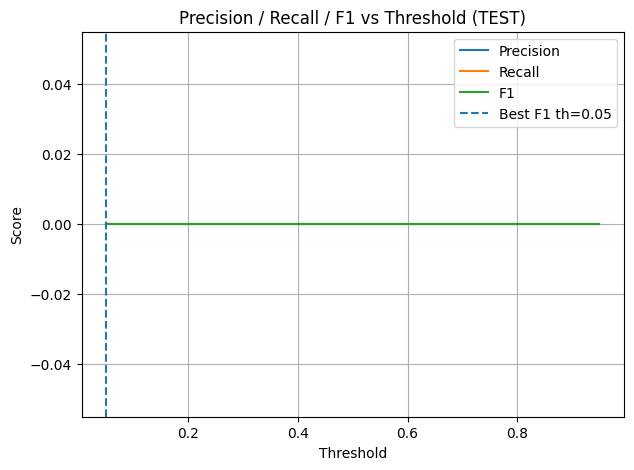

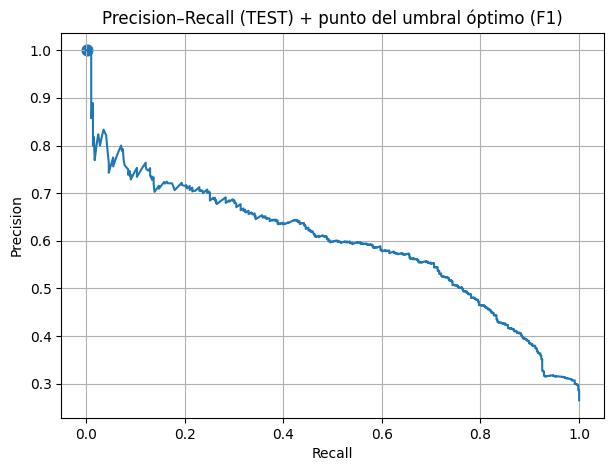


✅ Resumen optimización de umbral (TEST):


,best_threshold_f1,best_f1,precision_at_best_f1,recall_at_best_f1,accuracy_at_best_f1,precision_min_constraint,best_threshold_recall_with_precision_min
0,0.05,0.0,0.0,0.0,0.734501,0.4,None


In [ ]:
# =========================
# BLOQUE 10: Optimización de umbral (threshold) — TEST
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    precision_recall_curve
)

# 1) Definimos una grilla de umbrales
thresholds = np.arange(0.05, 0.96, 0.01)

rows = []
for th in thresholds:
    y_pred_th = (y_test_score_nb >= th).astype(int)

    rows.append({
        "threshold": th,
        "accuracy": accuracy_score(y_test, y_pred_th),
        "precision": precision_score(y_test, y_pred_th, zero_division=0),
        "recall": recall_score(y_test, y_pred_th, zero_division=0),
        "f1": f1_score(y_test, y_pred_th, zero_division=0)
    })

df_th = pd.DataFrame(rows)

# 2) Selección automática: umbral que maximiza F1
best_f1_row = df_th.loc[df_th["f1"].idxmax()]
best_th_f1 = float(best_f1_row["threshold"])

print(" Mejor umbral por F1:")
display(best_f1_row.to_frame().T)

# 3) Selección automática (opcional): maximizar Recall con precisión mínima
#    Ajusta precision_min según tu criterio de negocio (ej: 0.30, 0.40, 0.50)
precision_min = 0.40

candidates = df_th[df_th["precision"] >= precision_min].copy()
if len(candidates) > 0:
    best_recall_row = candidates.loc[candidates["recall"].idxmax()]
    best_th_recall = float(best_recall_row["threshold"])
    print(f" Mejor umbral max Recall con precision >= {precision_min}:")
    display(best_recall_row.to_frame().T)
else:
    best_th_recall = None
    print(f" No hay thresholds con precision >= {precision_min}. Baja el valor de precision_min.")

# 4) Gráfico: métricas vs threshold
plt.figure()
plt.plot(df_th["threshold"], df_th["precision"], label="Precision")
plt.plot(df_th["threshold"], df_th["recall"], label="Recall")
plt.plot(df_th["threshold"], df_th["f1"], label="F1")
plt.axvline(best_th_f1, linestyle="--", label=f"Best F1 th={best_th_f1:.2f}")
if best_th_recall is not None:
    plt.axvline(best_th_recall, linestyle="--", label=f"Best Recall th={best_th_recall:.2f}")
plt.title("Precision / Recall / F1 vs Threshold (TEST)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

# 5) Curva Precision–Recall y marcación del punto del mejor F1
prec_curve, rec_curve, pr_thresholds = precision_recall_curve(y_test, y_test_score_nb)

plt.figure()
plt.plot(rec_curve, prec_curve)

# Para marcar el punto del best_th_f1 en la curva PR:
# buscamos el índice de threshold más cercano en pr_thresholds
idx = np.argmin(np.abs(pr_thresholds - best_th_f1))
plt.scatter(rec_curve[idx], prec_curve[idx], s=60)
plt.title("Precision–Recall (TEST) + punto del umbral óptimo (F1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# 6) Guardar resultados para reporte/comparación
threshold_optimization_results = {
    "best_threshold_f1": best_th_f1,
    "best_f1": float(best_f1_row["f1"]),
    "precision_at_best_f1": float(best_f1_row["precision"]),
    "recall_at_best_f1": float(best_f1_row["recall"]),
    "accuracy_at_best_f1": float(best_f1_row["accuracy"]),
    "precision_min_constraint": precision_min,
    "best_threshold_recall_with_precision_min": best_th_recall
}

print("\n✅ Resumen optimización de umbral (TEST):")
display(pd.DataFrame([threshold_optimization_results]))


📌 Qué debes concluir (texto breve para tu informe)

* El umbral 0.5 no es necesariamente óptimo en churn.

* Ajustar el threshold puede aumentar recall (detectar más churners) a cambio de más falsos positivos.

* El umbral óptimo depende del objetivo:
* * Max F1 si buscas equilibrio precision/recall.
* * Max recall con precision mínima si la prioridad es retención.

### BLOQUE 11 — SVM Lineal: GridSearchCV + Evaluación CV (métricas + ROC/PR promedio) + tiempos

¿Qué se desarrolla en este bloque?

Se construye y evalúa un modelo SVM con kernel lineal, incluyendo:

*  Pipeline completo: preprocess + SVC(kernel="linear")
*  Selección de hiperparámetro C con GridSearchCV
*  Métrica objetivo: PR-AUC (Average Precision) (adecuada en churn desbalanceado)
*  Medición de tiempo de entrenamiento/búsqueda
*  Evaluación del mejor modelo con:
* * métricas por fold (Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC)
* * curvas ROC/PR promedio en CV
* * matriz de confusión acumulada (CV)

¿Por qué es importante?

* SVM lineal es un excelente baseline fuerte y suele funcionar bien en alta dimensión (one-hot).

* C controla el trade-off margen vs errores:
* * C bajo → margen amplio (más regularización, menos sobreajuste)
* * C alto → margen estrecho (puede sobreajustar)
* El GridSearch aporta rigurosidad: no se elige un C arbitrario.

Fitting 5 folds for each of 5 candidates, totalling 25 fits

✅ Mejor configuración SVM lineal (por PR-AUC):
{'svm__C': 0.1}

✅ Mejor PR-AUC promedio (CV train):
0.6541217649553155

⏱️ Tiempo total GridSearch (segundos): 42.294
===== SVM Lineal (best por GridSearch) — CV =====


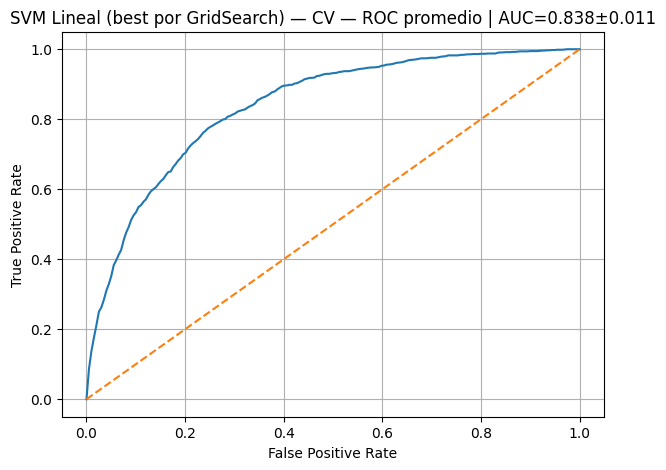

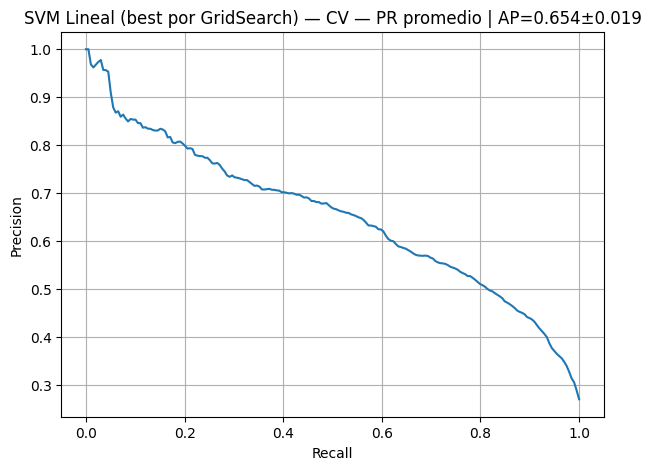

,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.808316,0.689474,0.501916,0.580931,0.829174,0.664831
1,2,0.807302,0.680203,0.513410,0.585153,0.846949,0.658889
2,3,0.784990,0.619048,0.496183,0.550847,0.826252,0.621196
3,4,0.808316,0.676329,0.534351,0.597015,0.835601,0.657892
4,5,0.811359,0.662393,0.591603,0.625000,0.850320,0.667857


,mean,std
accuracy,0.804057,0.010767
precision,0.665489,0.027729
recall,0.527493,0.038697
f1,0.587789,0.026872
roc_auc,0.837659,0.010642
pr_auc,0.654133,0.018871


Matriz de confusión acumulada (suma de folds):


,Pred 0,Pred 1
Real 0,3274,348
Real 1,618,690



✅ Resumen SVM lineal (CV) guardado:


,model,best_params,best_pr_auc_grid,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,f1_mean,f1_std,grid_time_seconds
0,SVM Lineal (GridSearch best) — CV,{'svm__C': 0.1},0.654122,0.837659,0.010642,0.654133,0.018871,0.587789,0.026872,42.294286


In [ ]:
# =========================
# BLOQUE 11: SVM lineal — GridSearchCV + CV report (ROC/PR promedio) + tiempo
# =========================

import time
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1) Definimos el pipeline: preprocesamiento + SVM lineal
# probability=True permite predict_proba (necesario para ROC/PR)
svm_linear_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svm", SVC(kernel="linear", probability=True))
])

# 2) Grilla de hiperparámetros (C)
param_grid_linear = {
    "svm__C": [0.01, 0.1, 1, 10, 100]
}

# 3) CV estratificada (mantiene proporción de churn en cada fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# 4) Ejecutamos GridSearchCV midiendo tiempo
t0 = time.perf_counter()

grid_linear = GridSearchCV(
    estimator=svm_linear_pipe,
    param_grid=param_grid_linear,
    scoring="average_precision",   # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_linear.fit(X_train, y_train)

elapsed_grid = time.perf_counter() - t0

print("\n Mejor configuración SVM lineal (por PR-AUC):")
print(grid_linear.best_params_)

print("\n Mejor PR-AUC promedio (CV train):")
print(grid_linear.best_score_)

print("\n Tiempo total GridSearch (segundos):", round(elapsed_grid, 3))

best_svm_linear = grid_linear.best_estimator_

# 5) Re-evaluación del mejor modelo en CV con nuestras funciones
df_svmL_cv, curves_svmL, conf_svmL = evaluate_cv_classifier(
    estimator=best_svm_linear,
    X_data=X_train.reset_index(drop=True),
    y_data=y_train.reset_index(drop=True),
    cv_splits=5,
    threshold=0.5
)

summary_svmL = show_cv_report_plots_first(
    df_metrics=df_svmL_cv,
    curves=curves_svmL,
    conf_total=conf_svmL,
    model_name="SVM Lineal (best por GridSearch) — CV",
    show_plots=True
)

# 6) Guardar resultados para comparación posterior
svm_linear_cv_results = {
    "model": "SVM Lineal (GridSearch best) — CV",
    "best_params": grid_linear.best_params_,
    "best_pr_auc_grid": float(grid_linear.best_score_),
    "roc_auc_mean": curves_svmL["roc_auc_mean"],
    "roc_auc_std": curves_svmL["roc_auc_std"],
    "pr_auc_mean": curves_svmL["pr_auc_mean"],
    "pr_auc_std": curves_svmL["pr_auc_std"],
    "f1_mean": float(df_svmL_cv["f1"].mean()),
    "f1_std": float(df_svmL_cv["f1"].std()),
    "grid_time_seconds": float(elapsed_grid)
}

print("\n Resumen SVM lineal (CV) guardado:")
display(pd.DataFrame([svm_linear_cv_results]))


### BLOQUE 12 — SVM RBF: GridSearchCV + RandomizedSearchCV + Evaluación CV (ROC/PR promedio) + comparación de tiempos

¿Qué se desarrolla en este bloque?

Este bloque entrena un SVM con kernel RBF (no lineal) y compara dos estrategias de búsqueda de hiperparámetros:

-  GridSearchCV (búsqueda exhaustiva)
-  RandomizedSearchCV (búsqueda eficiente en espacios grandes)

Además, para el mejor modelo de cada búsqueda:

-  Evalúa con CV usando las funciones del Bloque 5
-  Muestra:

* * Accuracy, Precision, Recall, F1
* * ROC-AUC, PR-AUC
* * ROC/PR promedio
* * Matriz de confusión acumulada
- - -  Mide tiempos y compara rendimiento

¿Por qué esto es clave en la Actividad 3?

- El kernel RBF captura relaciones no lineales.
- Los hiperparámetros son sensibles:

- - C controla regularización (margen vs errores)

- - gamma controla “radio de influencia” de los puntos

- Grid puede ser muy caro; Random Search puede lograr resultados similares con menos tiempo.

Si se omite: no cumples la parte de comparar estrategias de tuning y pierdes evidencia de optimización real.

Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ [GRID] Mejor configuración: {'svm__C': 100, 'svm__gamma': 0.001}
✅ [GRID] Mejor PR-AUC (CV train): 0.654609835160952
⏱️ [GRID] Tiempo (s): 101.49
===== SVM RBF (best por GRID) — CV =====


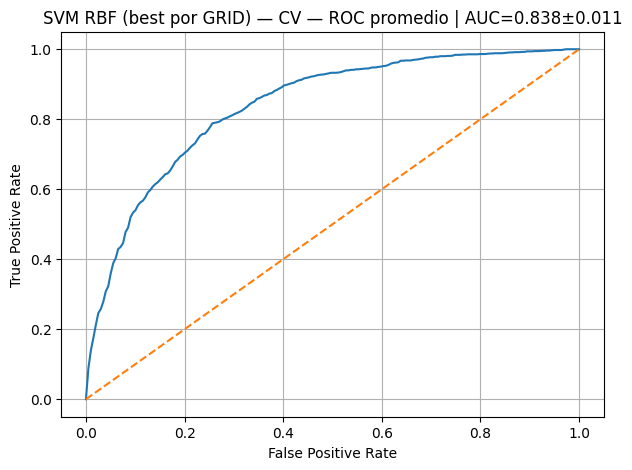

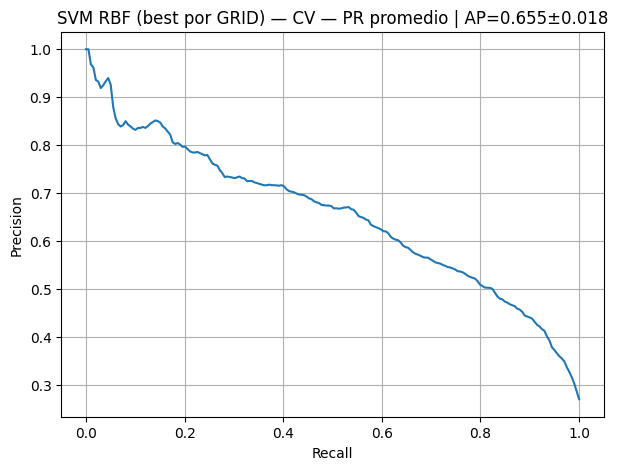

,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.806288,0.692308,0.482759,0.568849,0.829874,0.667250
1,2,0.808316,0.691489,0.498084,0.579065,0.846421,0.656402
2,3,0.786004,0.626866,0.480916,0.544276,0.826310,0.625179
3,4,0.801217,0.670103,0.496183,0.570175,0.837085,0.653024
4,5,0.814402,0.677130,0.576336,0.622680,0.851770,0.670951


,mean,std
accuracy,0.803245,0.010733
precision,0.671579,0.026732
recall,0.506856,0.039598
f1,0.577009,0.028613
roc_auc,0.838292,0.010766
pr_auc,0.654561,0.018019


Matriz de confusión acumulada (suma de folds):


,Pred 0,Pred 1
Real 0,3297,325
Real 1,645,663


Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ [RANDOM] Mejor configuración: {'svm__C': np.float64(98.77700294007911), 'svm__gamma': np.float64(0.0007068974950624604)}
✅ [RANDOM] Mejor PR-AUC (CV train): 0.655347647095909
⏱️ [RANDOM] Tiempo (s): 115.726
===== SVM RBF (best por RANDOM) — CV =====


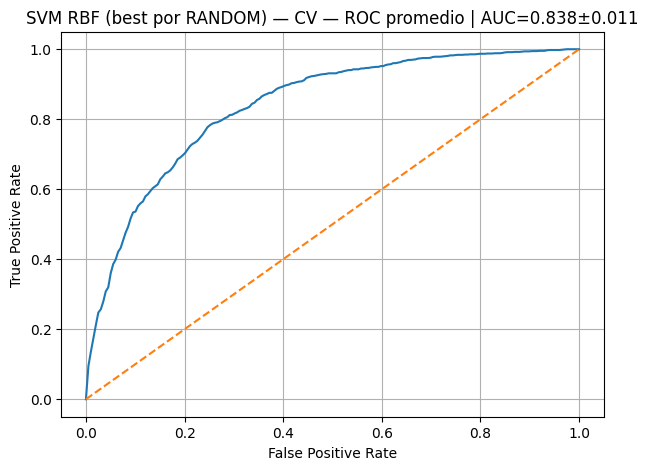

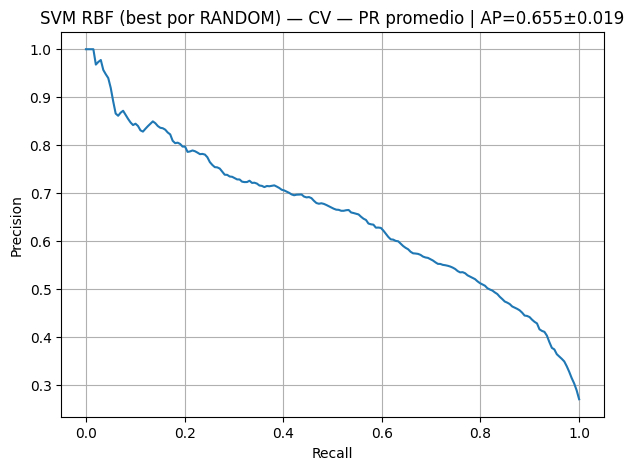

,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.807302,0.687831,0.498084,0.577778,0.829848,0.666973
1,2,0.804260,0.677083,0.498084,0.573951,0.846767,0.658940
2,3,0.788032,0.628019,0.496183,0.554371,0.826610,0.623480
3,4,0.807302,0.680000,0.519084,0.588745,0.836421,0.656961
4,5,0.815416,0.675439,0.587786,0.628571,0.851290,0.670591


,mean,std
accuracy,0.804462,0.010076
precision,0.669674,0.023767
recall,0.519844,0.039126
f1,0.584683,0.027497
roc_auc,0.838187,0.010630
pr_auc,0.655389,0.018699


Matriz de confusión acumulada (suma de folds):


,Pred 0,Pred 1
Real 0,3286,336
Real 1,628,680



✅ Comparación GRID vs RANDOM (SVM RBF):


,search,best_params,best_pr_auc_search,pr_auc_mean_cv,pr_auc_std_cv,roc_auc_mean_cv,roc_auc_std_cv,f1_mean_cv,time_seconds
0,GRID,"{'svm__C': 100, 'svm__gamma': 0.001}",0.654610,0.654561,0.018019,0.838292,0.010766,0.577009,101.489988
1,RANDOM,"{'svm__C': 98.77700294007911, 'svm__gamma': 0....",0.655348,0.655389,0.018699,0.838187,0.010630,0.584683,115.725740



🏁 Mejor SVM RBF final según PR-AUC medio en CV: RANDOM


In [ ]:
# =========================
# BLOQUE 12: SVM RBF — GridSearch vs RandomizedSearch + CV report + tiempos
# =========================

import time
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# 1) Pipeline: preprocesamiento + SVM RBF
svm_rbf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svm", SVC(kernel="rbf", probability=True))
])

# 2) CV estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# -------------------------
# A) GRID SEARCH (exhaustivo)
# -------------------------
param_grid_rbf = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001]
}

t0 = time.perf_counter()
grid_rbf = GridSearchCV(
    estimator=svm_rbf_pipe,
    param_grid=param_grid_rbf,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_rbf.fit(X_train, y_train)
time_grid = time.perf_counter() - t0

best_svm_rbf_grid = grid_rbf.best_estimator_

print("\n [GRID] Mejor configuración:", grid_rbf.best_params_)
print(" [GRID] Mejor PR-AUC (CV train):", grid_rbf.best_score_)
print(" [GRID] Tiempo (s):", round(time_grid, 3))

# Evaluación CV del mejor por GRID
df_rbf_grid_cv, curves_rbf_grid, conf_rbf_grid = evaluate_cv_classifier(
    estimator=best_svm_rbf_grid,
    X_data=X_train.reset_index(drop=True),
    y_data=y_train.reset_index(drop=True),
    cv_splits=5,
    threshold=0.5
)

summary_rbf_grid = show_cv_report_plots_first(
    df_metrics=df_rbf_grid_cv,
    curves=curves_rbf_grid,
    conf_total=conf_rbf_grid,
    model_name="SVM RBF (best por GRID) — CV",
    show_plots=True
)

# -----------------------------
# B) RANDOMIZED SEARCH (eficiente)
# -----------------------------
# Usamos distribuciones loguniform si scipy está disponible, si no, listas discretas.
try:
    from scipy.stats import loguniform
    param_dist_rbf = {
        "svm__C": loguniform(1e-3, 1e3),
        "svm__gamma": loguniform(1e-4, 1e0)
    }
except Exception:
    param_dist_rbf = {
        "svm__C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
        "svm__gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1]
    }

n_iter = 20  # puedes subir a 30-50 si tienes tiempo/CPU

t0 = time.perf_counter()
rand_rbf = RandomizedSearchCV(
    estimator=svm_rbf_pipe,
    param_distributions=param_dist_rbf,
    n_iter=n_iter,
    scoring="average_precision",
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)
rand_rbf.fit(X_train, y_train)
time_rand = time.perf_counter() - t0

best_svm_rbf_rand = rand_rbf.best_estimator_

print("\n [RANDOM] Mejor configuración:", rand_rbf.best_params_)
print(" [RANDOM] Mejor PR-AUC (CV train):", rand_rbf.best_score_)
print(" [RANDOM] Tiempo (s):", round(time_rand, 3))

# Evaluación CV del mejor por RANDOM
df_rbf_rand_cv, curves_rbf_rand, conf_rbf_rand = evaluate_cv_classifier(
    estimator=best_svm_rbf_rand,
    X_data=X_train.reset_index(drop=True),
    y_data=y_train.reset_index(drop=True),
    cv_splits=5,
    threshold=0.5
)

summary_rbf_rand = show_cv_report_plots_first(
    df_metrics=df_rbf_rand_cv,
    curves=curves_rbf_rand,
    conf_total=conf_rbf_rand,
    model_name="SVM RBF (best por RANDOM) — CV",
    show_plots=True
)

# -----------------------------
# C) Comparación resumen (GRID vs RANDOM)
# -----------------------------
svm_rbf_search_comparison = pd.DataFrame([
    {
        "search": "GRID",
        "best_params": grid_rbf.best_params_,
        "best_pr_auc_search": float(grid_rbf.best_score_),
        "pr_auc_mean_cv": curves_rbf_grid["pr_auc_mean"],
        "pr_auc_std_cv": curves_rbf_grid["pr_auc_std"],
        "roc_auc_mean_cv": curves_rbf_grid["roc_auc_mean"],
        "roc_auc_std_cv": curves_rbf_grid["roc_auc_std"],
        "f1_mean_cv": float(df_rbf_grid_cv["f1"].mean()),
        "time_seconds": float(time_grid)
    },
    {
        "search": "RANDOM",
        "best_params": rand_rbf.best_params_,
        "best_pr_auc_search": float(rand_rbf.best_score_),
        "pr_auc_mean_cv": curves_rbf_rand["pr_auc_mean"],
        "pr_auc_std_cv": curves_rbf_rand["pr_auc_std"],
        "roc_auc_mean_cv": curves_rbf_rand["roc_auc_mean"],
        "roc_auc_std_cv": curves_rbf_rand["roc_auc_std"],
        "f1_mean_cv": float(df_rbf_rand_cv["f1"].mean()),
        "time_seconds": float(time_rand)
    }
])

print("\n✅ Comparación GRID vs RANDOM (SVM RBF):")
display(svm_rbf_search_comparison)

# Guardar el "mejor global" según PR-AUC medio en CV
if curves_rbf_grid["pr_auc_mean"] >= curves_rbf_rand["pr_auc_mean"]:
    best_svm_rbf = best_svm_rbf_grid
    best_svm_rbf_source = "GRID"
else:
    best_svm_rbf = best_svm_rbf_rand
    best_svm_rbf_source = "RANDOM"

print(f"\n🏁 Mejor SVM RBF final según PR-AUC medio en CV: {best_svm_rbf_source}")


¿Qué debes reportar/interpretar en tu informe?

GridSearch suele ser más lento pero sistemático.

RandomizedSearch puede lograr resultados comparables más rápido, especialmente si el espacio de búsqueda es grande.

En churn, prioriza comparar por PR-AUC y luego revisar Recall y Precision (según estrategia de retención).

### BLOQUE 13 — Evaluación FINAL en TEST: Naïve Bayes (best) vs SVM lineal (best) vs SVM RBF (best) + Curvas ROC/PR + Tabla comparativa

¿Qué se desarrolla en este bloque?

Este bloque realiza la evaluación final (TEST) de los mejores modelos obtenidos:

*  Naïve Bayes optimizado (best_nb)
*  SVM Lineal optimizado (best_svm_linear)
*  SVM RBF optimizado (best_svm_rbf) (definido en Bloque 12 como el mejor entre GRID/RANDOM)

Entregando para cada modelo en TEST:

* Accuracy, Precision, Recall, F1

* ROC-AUC

* PR-AUC (Average Precision)

* Matriz de confusión

* Curvas ROC y Precision–Recall

* Tabla comparativa final ordenada por PR-AUC

¿Por qué es importante?

* Esta es la evidencia de desempeño en datos no vistos (lo más parecido a “producción”).

* En churn, PR-AUC suele ser la métrica más útil.

* Se comparan modelos bajo el mismo criterio (mismo split test, mismas métricas).

Si se omite: no tienes una comparación final rigurosa ni conclusiones técnicas sólidas.


TEST — Naïve Bayes (best)
Umbral: 0.5
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1552
           1       0.00      0.00      0.00       561

    accuracy                           0.73      2113
   macro avg       0.37      0.50      0.42      2113
weighted avg       0.54      0.73      0.62      2113

Matriz de confusión (test):


,Pred 0,Pred 1
Real 0,1552,0
Real 1,561,0


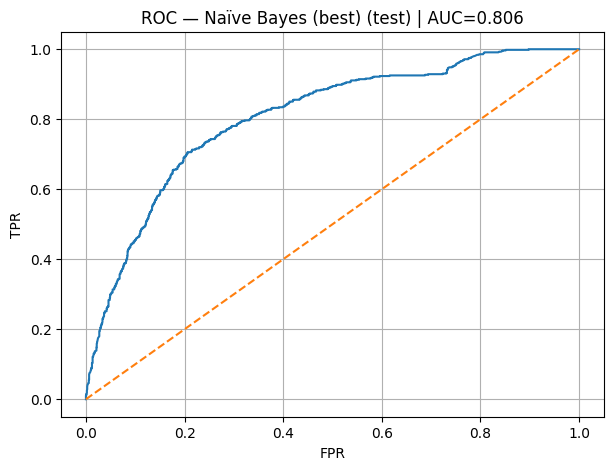

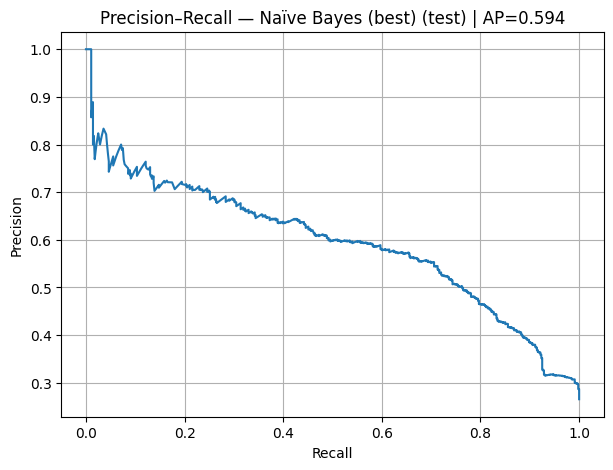


TEST — SVM Lineal (best)
Umbral: 0.5
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1552
           1       0.65      0.53      0.58       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113

Matriz de confusión (test):


,Pred 0,Pred 1
Real 0,1395,157
Real 1,266,295


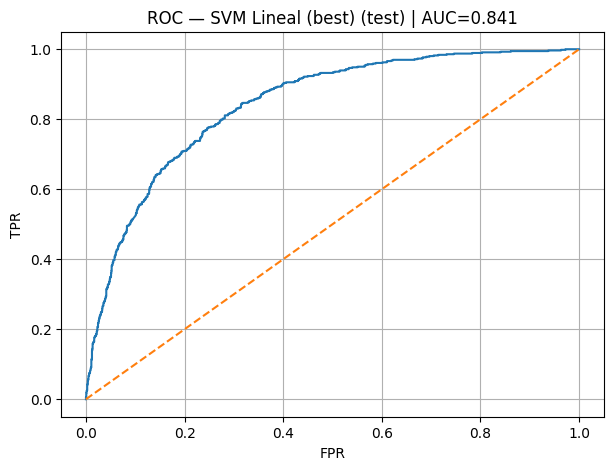

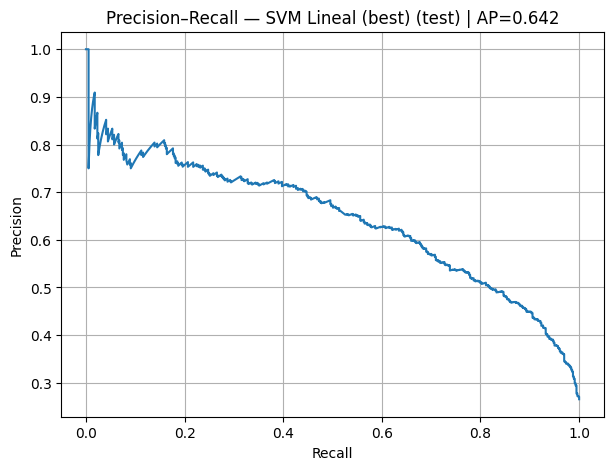


TEST — SVM RBF (best)
Umbral: 0.5
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.67      0.52      0.58       561

    accuracy                           0.81      2113
   macro avg       0.76      0.71      0.73      2113
weighted avg       0.79      0.81      0.80      2113

Matriz de confusión (test):


,Pred 0,Pred 1
Real 0,1412,140
Real 1,272,289


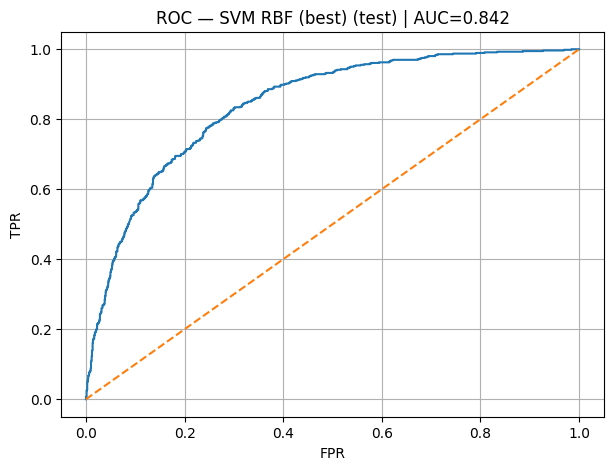

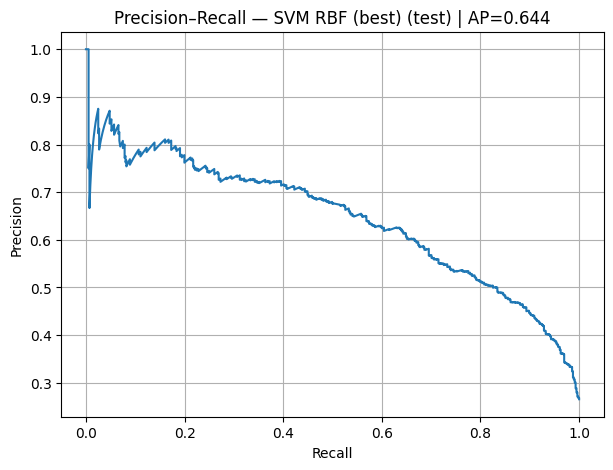


✅ Comparación final (TEST) — ordenada por PR-AUC:


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
2,SVM RBF (best),0.805017,0.673660,0.515152,0.583838,0.842202,0.644178
1,SVM Lineal (best),0.799811,0.652655,0.525847,0.582428,0.841344,0.641918
0,Naïve Bayes (best),0.734501,0.000000,0.000000,0.000000,0.805766,0.593669


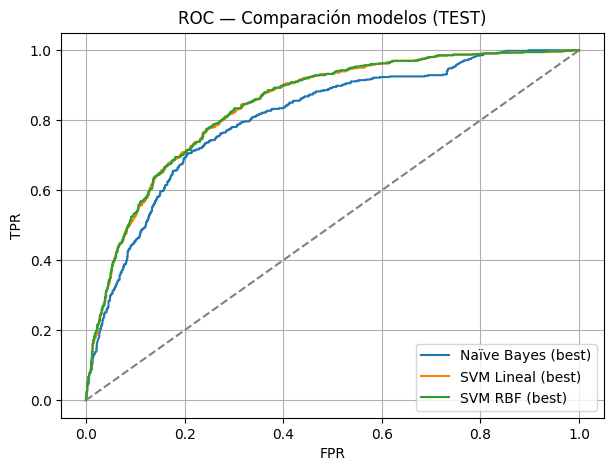

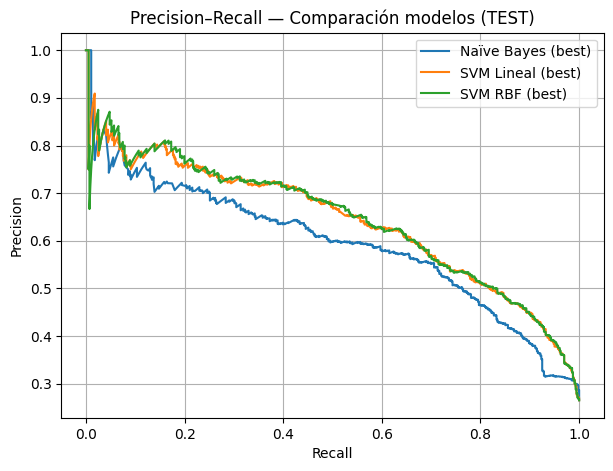


📌 Conclusión (base para informe):
- El mejor modelo según PR-AUC en TEST es: SVM RBF (best)
- PR-AUC=0.644, ROC-AUC=0.842, F1=0.584
- En churn desbalanceado, PR-AUC suele ser la métrica prioritaria.
- Si el objetivo de negocio es reducir falsos negativos (no perder churners), revisa especialmente el Recall.


In [ ]:
# =========================
# BLOQUE 13: Evaluación FINAL en TEST — NB vs SVM lineal vs SVM RBF
# =========================

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)

def eval_model_on_test(estimator, name):
    """
    Entrena en train y evalúa en test:
      - métricas: accuracy, precision, recall, f1, roc_auc, pr_auc
      - matriz de confusión
      - curvas ROC y PR
    Retorna:
      - dict con métricas
      - (fpr, tpr) ROC
      - (recall_curve, precision_curve) PR
    """
    estimator.fit(X_train, y_train)

    # Score: usamos predict_proba si existe
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X_test)[:, 1]
    else:
        # fallback (por si acaso): decision_function
        y_score = estimator.decision_function(X_test)

    threshold = 0.5
    y_pred = (y_score >= threshold).astype(int)

    print(f"\n==============================")
    print(f"TEST — {name}")
    print(f"Umbral: {threshold}")
    print("==============================")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    print("Matriz de confusión (test):")
    display(pd.DataFrame(cm, index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"]))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    roc_auc = roc_auc_score(y_test, y_score)
    pr_auc = average_precision_score(y_test, y_score)

    # Curvas
    fpr, tpr, _ = roc_curve(y_test, y_score)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_score)

    # Mostrar curvas individuales (una celda por modelo)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], "--")
    plt.title(f"ROC — {name} (test) | AUC={roc_auc:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.show()

    plt.figure()
    plt.plot(recall_curve, precision_curve)
    plt.title(f"Precision–Recall — {name} (test) | AP={pr_auc:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.show()

    metrics = {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

    return metrics, (fpr, tpr), (recall_curve, precision_curve)

# 1) Evaluación individual por modelo + gráficos
results = []
roc_curves = {}
pr_curves = {}

m_nb, roc_nb, pr_nb = eval_model_on_test(best_nb, "Naïve Bayes (best)")
results.append(m_nb); roc_curves[m_nb["model"]] = roc_nb; pr_curves[m_nb["model"]] = pr_nb

m_svmL, roc_svmL, pr_svmL = eval_model_on_test(best_svm_linear, "SVM Lineal (best)")
results.append(m_svmL); roc_curves[m_svmL["model"]] = roc_svmL; pr_curves[m_svmL["model"]] = pr_svmL

m_svmR, roc_svmR, pr_svmR = eval_model_on_test(best_svm_rbf, "SVM RBF (best)")
results.append(m_svmR); roc_curves[m_svmR["model"]] = roc_svmR; pr_curves[m_svmR["model"]] = pr_svmR

# 2) Tabla comparativa final (ordenada por PR-AUC)
df_results_test = pd.DataFrame(results).sort_values(by="pr_auc", ascending=False)
print("\n✅ Comparación final (TEST) — ordenada por PR-AUC:")
display(df_results_test)

# 3) Gráficos comparativos en una sola figura (ROC y PR)
#    Esto ayuda mucho para informes y defensa
plt.figure()
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], "--", color="gray")
plt.title("ROC — Comparación modelos (TEST)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend()
plt.show()

plt.figure()
for name, (rec_curve, prec_curve) in pr_curves.items():
    plt.plot(rec_curve, prec_curve, label=name)
plt.title("Precision–Recall — Comparación modelos (TEST)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.show()

# 4) Conclusiones automáticas (texto base para informe)
best_by_pr = df_results_test.iloc[0]
print("\n📌 Conclusión (base para informe):")
print(f"- El mejor modelo según PR-AUC en TEST es: {best_by_pr['model']}")
print(f"- PR-AUC={best_by_pr['pr_auc']:.3f}, ROC-AUC={best_by_pr['roc_auc']:.3f}, F1={best_by_pr['f1']:.3f}")
print("- En churn desbalanceado, PR-AUC suele ser la métrica prioritaria.")
print("- Si el objetivo de negocio es reducir falsos negativos (no perder churners), revisa especialmente el Recall.")


### BLOQUE 14 — SVM con desbalance: class_weight='balanced' + Evaluación TEST + Comparación directa

¿Qué se desarrolla en este bloque?

En churn, la clase positiva (churn=1) suele ser minoritaria. Un SVM “normal” tiende a favorecer la clase mayoritaria.
Este bloque incorpora balanceo de clases mediante:

*  class_weight='balanced' en SVM Lineal y SVM RBF
*  Re-entrena usando los mejores hiperparámetros ya encontrados
*  Evalúa en TEST con:

* * Accuracy, Precision, Recall, F1

* * ROC-AUC

* * PR-AUC

* * Matriz de confusión

* * Curvas ROC y PR
* * *  Agrega los resultados a una tabla comparativa final

¿Por qué es importante?

class_weight='balanced' repondera los errores por clase usando pesos inversamente proporcionales a su frecuencia, lo que típicamente:

*  Aumenta Recall de churn (detecta más churners)

*  Puede bajar Precision (más falsos positivos)

Si se omite: podrías reportar un modelo “óptimo” por AUC pero con recall insuficiente para objetivos de retención.

✅ Parámetros usados para SVM balanced:
 - Lineal: C = 0.1
 - RBF:    C = 98.77700294007911 | gamma = 0.0007068974950624604

TEST — SVM Lineal (balanced)
Umbral: 0.5
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1552
           1       0.65      0.60      0.62       561

    accuracy                           0.81      2113
   macro avg       0.75      0.74      0.75      2113
weighted avg       0.80      0.81      0.80      2113

Matriz de confusión (test):


,Pred 0,Pred 1
Real 0,1366,186
Real 1,223,338


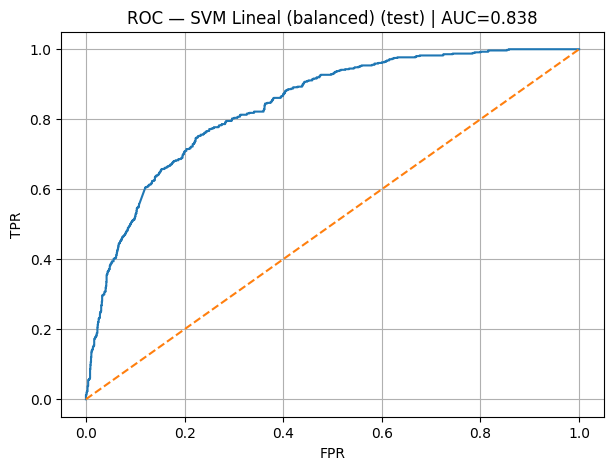

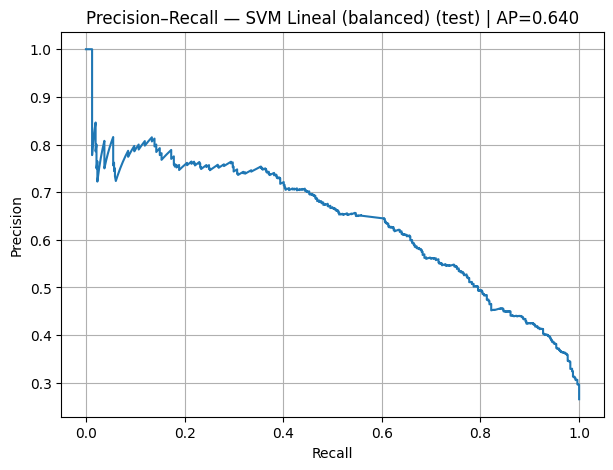


TEST — SVM RBF (balanced)
Umbral: 0.5
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1552
           1       0.64      0.59      0.62       561

    accuracy                           0.80      2113
   macro avg       0.75      0.74      0.74      2113
weighted avg       0.80      0.80      0.80      2113

Matriz de confusión (test):


,Pred 0,Pred 1
Real 0,1366,186
Real 1,229,332


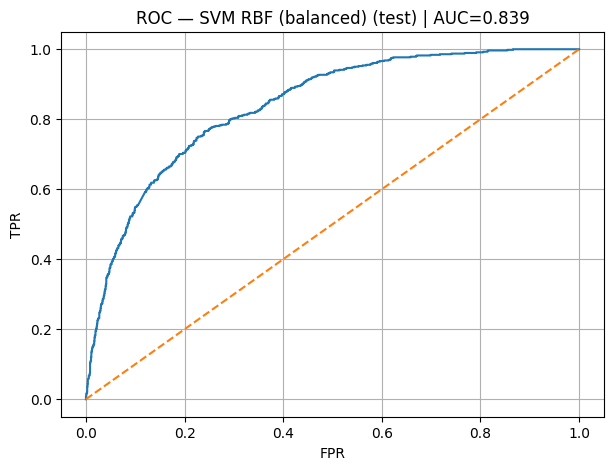

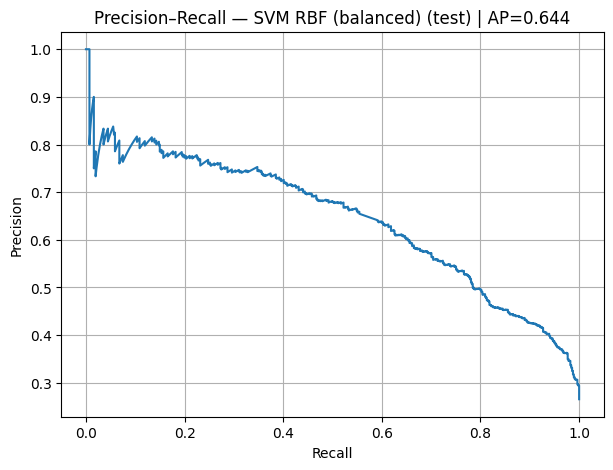


✅ Tabla comparativa extendida (incluye balanced):


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,SVM RBF (best),0.805017,0.673660,0.515152,0.583838,0.842202,0.644178
4,SVM RBF (balanced),0.803597,0.640927,0.591800,0.615385,0.839167,0.644023
1,SVM Lineal (best),0.799811,0.652655,0.525847,0.582428,0.841344,0.641918
3,SVM Lineal (balanced),0.806436,0.645038,0.602496,0.623041,0.837964,0.640325
2,Naïve Bayes (best),0.734501,0.000000,0.000000,0.000000,0.805766,0.593669


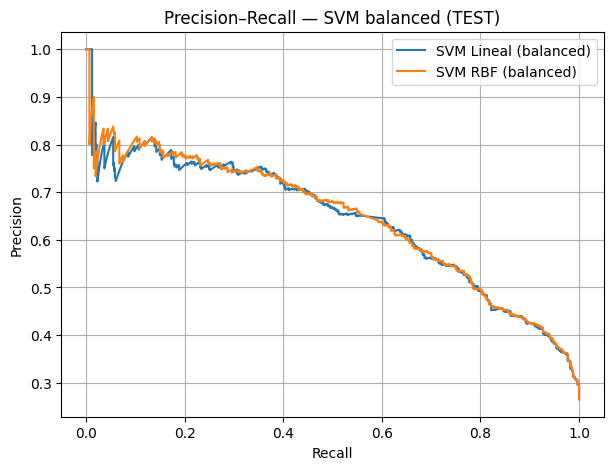


📌 Interpretación (base para informe):
- balanced suele aumentar Recall (detecta más churners), a costa de más falsos positivos (baja Precision).
- Evaluar si el equipo de retención puede absorber el aumento de casos predichos como churn.
- PR-AUC es clave para comparar modelos en escenarios desbalanceados.


In [ ]:
# =========================
# BLOQUE 14: SVM balanced — TEST + comparación
# =========================

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# 1) Recuperar mejores hiperparámetros ya aprendidos
best_C_linear = grid_linear.best_params_["svm__C"]

# Para RBF: usamos los parámetros del mejor modelo final (según Bloque 12)
# Extraemos los params desde el estimador interno svm del pipeline best_svm_rbf
rbf_params = best_svm_rbf.get_params()
best_C_rbf = rbf_params["svm__C"]
best_gamma_rbf = rbf_params["svm__gamma"]

print(" Parámetros usados para SVM balanced:")
print(" - Lineal: C =", best_C_linear)
print(" - RBF:    C =", best_C_rbf, "| gamma =", best_gamma_rbf)

# 2) Construir SVM lineal balanced con el mejor C
svm_linear_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svm", SVC(
        kernel="linear",
        C=best_C_linear,
        class_weight="balanced",
        probability=True
    ))
])

# 3) Construir SVM RBF balanced con los mejores C y gamma
svm_rbf_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svm", SVC(
        kernel="rbf",
        C=best_C_rbf,
        gamma=best_gamma_rbf,
        class_weight="balanced",
        probability=True
    ))
])

# 4) Evaluar ambos modelos en TEST (usa la función del Bloque 13)
m_svmL_bal, roc_svmL_bal, pr_svmL_bal = eval_model_on_test(svm_linear_balanced, "SVM Lineal (balanced)")
m_svmR_bal, roc_svmR_bal, pr_svmR_bal = eval_model_on_test(svm_rbf_balanced, "SVM RBF (balanced)")

# 5) Comparación rápida: agregar a tabla existente si existe, o crearla
try:
    df_results_test
    df_results_test_extended = pd.concat(
        [df_results_test, pd.DataFrame([m_svmL_bal, m_svmR_bal])],
        ignore_index=True
    )
except NameError:
    df_results_test_extended = pd.DataFrame([m_svmL_bal, m_svmR_bal])

df_results_test_extended = df_results_test_extended.sort_values(by="pr_auc", ascending=False)

print("\n Tabla comparativa extendida (incluye balanced):")
display(df_results_test_extended)

# 6) Gráficos comparativos de PR (muy útil en churn)
plt.figure()
plt.plot(pr_svmL_bal[0], pr_svmL_bal[1], label="SVM Lineal (balanced)")
plt.plot(pr_svmR_bal[0], pr_svmR_bal[1], label="SVM RBF (balanced)")
plt.title("Precision–Recall — SVM balanced (TEST)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()




### Interpretación automática breve (texto base para informe)
* Interpretación (base para informe):

* "- balanced suele aumentar Recall (detecta más churners), a costa de más falsos positivos (baja Precision)."
* "- Evaluar si el equipo de retención puede absorber el aumento de casos predichos como churn."
* "- PR-AUC es clave para comparar modelos en escenarios desbalanceados."

### BLOQUE 15 — Cierre del proyecto: ranking final + recomendación por escenario + conclusiones y mejoras

¿Qué se desarrolla en este bloque?

Este bloque consolida todos los resultados de TEST (modelos normales y balanced) en una tabla final, genera un ranking por métricas clave (especialmente PR-AUC), y entrega una recomendación final según dos escenarios típicos de churn:

* ✅ Escenario A: Priorizar Recall (no dejar escapar churners)
* ✅ Escenario B: Priorizar Precision (recursos limitados para retención)

Además:

* ✅ Texto de conclusiones académicas (metodología, validez, métricas)
* ✅ Sugerencias de mejora/extensión (calibración, threshold, costos, interpretabilidad)

In [ ]:
# =========================
# BLOQUE 15: Ranking final + recomendación por escenario + conclusiones
# =========================

import pandas as pd

# 1) Seleccionar la tabla más completa disponible
if "df_results_test_extended" in globals():
    df_final = df_results_test_extended.copy()
elif "df_results_test" in globals():
    df_final = df_results_test.copy()
else:
    raise NameError(
        "No existe df_results_test ni df_results_test_extended. "
        "Ejecuta los Bloques 13 y/o 14 primero."
    )

# 2) Ordenar por métricas relevantes para churn
df_final = (
    df_final
    .sort_values(by=["pr_auc", "f1", "recall"], ascending=False)
    .reset_index(drop=True)
)

print("✅ Tabla FINAL (TEST) — ordenada por PR-AUC, luego F1 y Recall:")
display(df_final)

# 3) Ranking por distintos criterios
top_pr_auc = df_final.iloc[0]
top_recall = df_final.sort_values(by="recall", ascending=False).iloc[0]
top_precision = df_final.sort_values(by="precision", ascending=False).iloc[0]
top_f1 = df_final.sort_values(by="f1", ascending=False).iloc[0]

ranking_summary = pd.DataFrame([
    {
        "criterio": "Mejor PR-AUC",
        "model": top_pr_auc["model"],
        "pr_auc": top_pr_auc["pr_auc"],
        "recall": top_pr_auc["recall"],
        "precision": top_pr_auc["precision"],
        "f1": top_pr_auc["f1"],
    },
    {
        "criterio": "Mejor Recall",
        "model": top_recall["model"],
        "pr_auc": top_recall["pr_auc"],
        "recall": top_recall["recall"],
        "precision": top_recall["precision"],
        "f1": top_recall["f1"],
    },
    {
        "criterio": "Mejor Precision",
        "model": top_precision["model"],
        "pr_auc": top_precision["pr_auc"],
        "recall": top_precision["recall"],
        "precision": top_precision["precision"],
        "f1": top_precision["f1"],
    },
    {
        "criterio": "Mejor F1",
        "model": top_f1["model"],
        "pr_auc": top_f1["pr_auc"],
        "recall": top_f1["recall"],
        "precision": top_f1["precision"],
        "f1": top_f1["f1"],
    },
])

print("\n✅ Ranking por criterio (TEST):")
display(ranking_summary)

# 4) Recomendación por escenarios de negocio
precision_min = 0.40
candidates = df_final[df_final["precision"] >= precision_min]

if len(candidates) > 0:
    best_for_recall_with_precision = (
        candidates.sort_values(by="recall", ascending=False).iloc[0]
    )
else:
    best_for_recall_with_precision = None

print("\n📌 RECOMENDACIÓN POR ESCENARIOS\n")

print("Escenario A — Priorizar Recall (no perder churners):")
print(
    f"- Modelo recomendado: {top_recall['model']} | "
    f"Recall={top_recall['recall']:.3f} | "
    f"Precision={top_recall['precision']:.3f} | "
    f"PR-AUC={top_recall['pr_auc']:.3f}"
)

print(f"\nEscenario A con restricción — Recall alto y Precision >= {precision_min}:")
if best_for_recall_with_precision is not None:
    print(
        f"- Modelo recomendado: {best_for_recall_with_precision['model']} | "
        f"Recall={best_for_recall_with_precision['recall']:.3f} | "
        f"Precision={best_for_recall_with_precision['precision']:.3f} | "
        f"PR-AUC={best_for_recall_with_precision['pr_auc']:.3f}"
    )
else:
    print(
        "- No hay modelos que cumplan la restricción de precisión mínima. "
        "Se recomienda optimizar el umbral (Bloque 10)."
    )

print("\nEscenario B — Priorizar Precision (recursos limitados):")
print(
    f"- Modelo recomendado: {top_precision['model']} | "
    f"Precision={top_precision['precision']:.3f} | "
    f"Recall={top_precision['recall']:.3f} | "
    f"PR-AUC={top_precision['pr_auc']:.3f}"
)

print("\nEscenario C — Mejor desempeño global (PR-AUC):")
print(
    f"- Modelo recomendado: {top_pr_auc['model']} | "
    f"PR-AUC={top_pr_auc['pr_auc']:.3f} | "
    f"Recall={top_pr_auc['recall']:.3f} | "
    f"Precision={top_pr_auc['precision']:.3f}"
)



### Conclusiones y mejoras (texto base para informe)



CONCLUSIONES (base para informe)



    "1) Se implementó un flujo reproducible con pipelines completos, evitando fuga de datos.\n"
    "2) Se utilizó validación cruzada estratificada para evaluar estabilidad y variabilidad.\n"
    "3) PR-AUC fue priorizada como métrica central dada la naturaleza desbalanceada del churn.\n"
    "4) La evaluación en TEST permitió estimar capacidad de generalización.\n"
    "5) El trade-off Precision–Recall fue analizado desde una perspectiva de negocio."


### MEJORAS Y EXTENSIONES FUTURAS

    "- Optimizar el umbral de decisión según objetivo de negocio.\n"
    "- Calibrar probabilidades (Platt / Isotonic).\n"
    "- Incorporar aprendizaje sensible a costos.\n"
    "- Reducir dimensionalidad o seleccionar variables.\n"
    "- Incorporar interpretabilidad (coeficientes SVM, SHAP, LIME)."


